# Stock Market Predictor (LSTM) (**Work in Progress**)
---
Howdy!

### **Introduction:**

For this project, I am using a Long Short-Term Memory Neural Network Model to predict stock price since this technique is good at noticing patterns in sequential data which can help make future predictions.



#### **Project Framework:**

**Data Obtaining:** Obtain stock price data by grabbing it fromm YahooFinance. To make this simple, I will only do predictions on one stock at a time (Starting With JP Morgan - JPM)

**Data Cleaning:** The data will then be cleaned getting rid of any missing values (not viable to fill nulls with mean). Clean the date data of the stock so that it can be put through the model

**Choose Model:** LSTM since we can include many variables that effect stock price. Not including corporate news sadly.

**Set Model Paramters:** This is still a machine learning technique so choosing the right paramters will be important when I train the model.

**Train the Model:** Run model with the stock data

## Load Libraries

In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install yfinance --upgrade --no-cache-dir


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Set the seaborn style

# -- Sklearn --
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# -- Date Libraries
from datetime import datetime
import matplotlib.dates as mdates

# -- Keras --
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# -- Yahoo Finance --
import yfinance as yf

## Extract Data from Yahoo Finance (In progress)

In [3]:
ticker = "JPM"

stock = yf.Ticker(ticker)

print(stock.info)



{'address1': '383 Madison Avenue', 'city': 'New York', 'state': 'NY', 'zip': '10179', 'country': 'United States', 'phone': '212 270 6000', 'website': 'https://www.jpmorganchase.com', 'industry': 'Banks - Diversified', 'industryKey': 'banks-diversified', 'industryDisp': 'Banks - Diversified', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': 'JPMorgan Chase & Co. operates as a financial services company worldwide. It operates through four segments: Consumer & Community Banking (CCB), Corporate & Investment Bank (CIB), Commercial Banking (CB), and Asset & Wealth Management (AWM). The CCB segment offers deposit, investment and lending products, cash management, and payments and services; mortgage origination and servicing activities; residential mortgages and home equity loans; and credit cards, auto loans, leases, and travel services to consumers and small businesses through bank branches, ATMs, and digital and t

## Load The data:

In [4]:
website = 'https://raw.githubusercontent.com/MikeVej/ML_StockPredictor/main/AAPL_historic_prices.csv'
df = pd.read_csv(website)

# Display the first few rows of the dataframe
df.head()
df["Date"] = pd.to_datetime(df["Date"])

## Data Prep:
---
Clean data: handle missing values, standardizing the data for neural network processing, and converting the time series data into a format suitable for training an LSTM model

Train, Test, Split: Split date is where the test data starts

In [5]:
# Parameters
sequence_length = 10  # Use 10 days of historical data to predict the next day price
split_date = '2023-01-01'  # Splitting the dataset into training and testing at this date

# Selecting the features ('Adj Close' and 'Volume') and the target ('Adj Close')
features = df[['Adj Close', 'Volume']]
target = df['Adj Close']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # Target is the 'Adj Close' price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
X, y = create_sequences(scaled_features, sequence_length)

# 'Date' column converted to datetime
df['Date'] = pd.to_datetime(df['Date'])


# First, find the index where the split should occur
split_idx = df[df['Date'] < split_date].shape[0] - sequence_length

# Use this index to split the sequenced data
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Verify the shapes of the split datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Print the shapes of the datasets to ensure they are not empty
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (966, 10, 2)
y_train shape: (966,)
X_test shape: (283, 10, 2)
y_test shape: (283,)


In [6]:

# Flatten the sequences
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # This will reshape X_train to (966, 20)

# Name columns
column_names = []
for i in range(1, X_train.shape[1] + 1):  # For each time step
    column_names.extend([f'Adj Close{i}', f'Volume{i}'])

df_X_train = pd.DataFrame(X_train_flattened, columns=column_names)

df_X_train.head()

,Adj Close1,Volume1,Adj Close2,Volume2,Adj Close3,Volume3,Adj Close4,Volume4,Adj Close5,Volume5,Adj Close6,Volume6,Adj Close7,Volume7,Adj Close8,Volume8,Adj Close9,Volume9,Adj Close10,Volume10
0,0.000000,0.128814,0.001689,0.199794,0.000200,0.111689,0.003133,0.128222,0.005068,0.157643,0.005221,0.109905,0.006051,0.216898,0.003409,0.220675,0.006204,0.197526,0.007556,0.212931
1,0.001689,0.199794,0.000200,0.111689,0.003133,0.128222,0.005068,0.157643,0.005221,0.109905,0.006051,0.216898,0.003409,0.220675,0.006204,0.197526,0.007556,0.212931,0.007064,0.136414
2,0.000200,0.111689,0.003133,0.128222,0.005068,0.157643,0.005221,0.109905,0.006051,0.216898,0.003409,0.220675,0.006204,0.197526,0.007556,0.212931,0.007064,0.136414,0.005513,0.147078
3,0.003133,0.128222,0.005068,0.157643,0.005221,0.109905,0.006051,0.216898,0.003409,0.220675,0.006204,0.197526,0.007556,0.212931,0.007064,0.136414,0.005513,0.147078,0.002411,0.186694
4,0.005068,0.157643,0.005221,0.109905,0.006051,0.216898,0.003409,0.220675,0.006204,0.197526,0.007556,0.212931,0.007064,0.136414,0.005513,0.147078,0.002411,0.186694,0.003041,0.178773


## Create/Define LSTM:

In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/50


C:\Users\mikel\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2000 - mean_absolute_error: 0.3664 - val_loss: 0.0036 - val_mean_absolute_error: 0.0514
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - mean_absolute_error: 0.0965 - val_loss: 0.0017 - val_mean_absolute_error: 0.0323
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0322 - val_loss: 0.0014 - val_mean_absolute_error: 0.0292
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0273 - val_loss: 0.0010 - val_mean_absolute_error: 0.0259
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5658e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0011 - val_mean_absolute_error: 0.0272
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0482e-04 - mean_absolute_error: 0.0232 - val_loss: 9.3042e-04 - val_mean_absolute_error: 0.0246
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4602e-04 - mean_absolute_error: 0.0209 - val_loss:

## Evaluate Model:

In [8]:
predictions = model.predict(X_test)

# Assuming your predictions are for 'Adj Close' and you initially scaled 'Adj Close' and 'Volume'
dummy_feature = np.zeros((predictions.shape[0], 1))  # Create a column of zeros for the dummy feature

# Concatenate your predictions with the dummy feature to match the original feature shape
predictions_with_dummy = np.hstack([predictions, dummy_feature])

# Apply the inverse transformation
predictions_inverse = scaler.inverse_transform(predictions_with_dummy)[:, 0]  # Select only the 'Adj Close' predictions

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


## Model Performance

In [9]:
rmse = np.sqrt(np.mean(history.history['loss']))
print(f'RMSE: {rmse:.4f}')

mae = np.mean(history.history['mean_absolute_error'])
print(f'MAE : {mae:.4f}')

RMSE: 0.0588
MAE : 0.0259


## Error in Dollars ($)

In [10]:
dummy_feature = np.zeros(predictions.shape)  # Create a dummy array with zeros

# Stack your predictions and the dummy feature to match the original shape
predictions_with_dummy = np.hstack([predictions, dummy_feature])

# Inversely transform and then select only the column with the predictions
predictions_inverse = scaler.inverse_transform(predictions_with_dummy)[:, 0]

# Repeat similar steps for y_test if needed
y_test_with_dummy = np.hstack([y_test.reshape(-1, 1), dummy_feature])
y_test_inverse = scaler.inverse_transform(y_test_with_dummy)[:, 0]

## RMSE

In [11]:
# Recalculate RMSE on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'RMSE on original scale.  : ${rmse_original:.2f}')

RMSE on original scale.  : $3.32


## MAE

In [12]:
# Recalculate MAE on the original scale
mae_original = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'MAE on original scale +/-: ${mae_original:.2f}')

MAE on original scale +/-: $2.71


## Predictions Plot

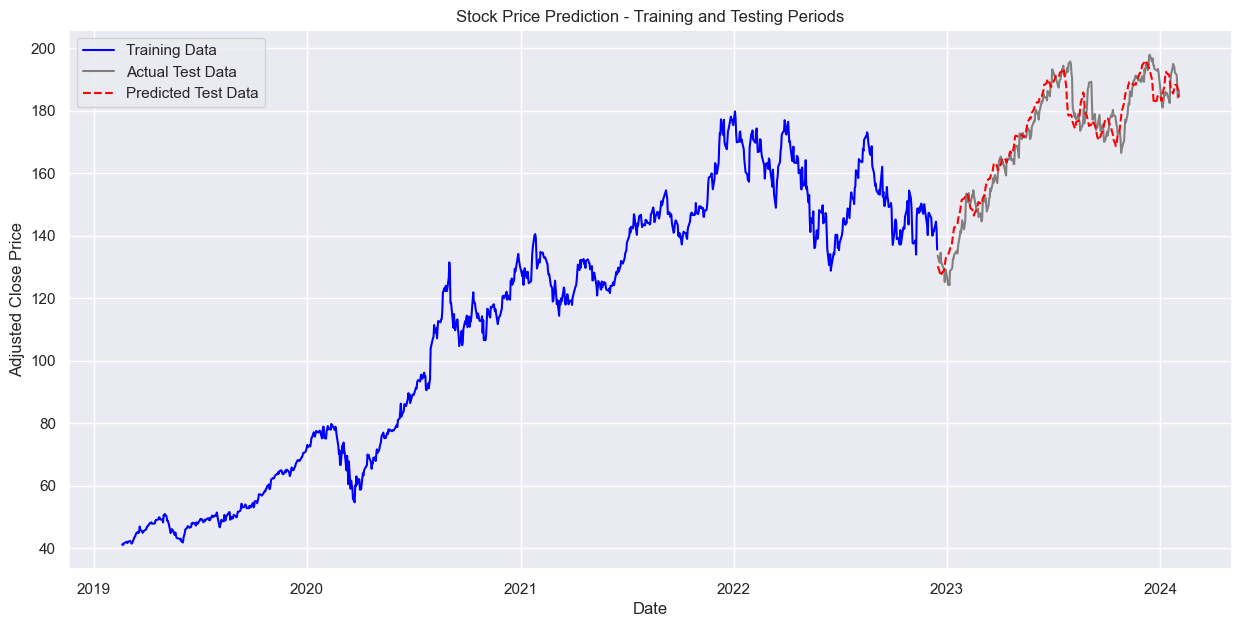

In [13]:
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(df['Date'][:len(y_train)], df['Adj Close'][:len(y_train)], color='blue', label='Training Data')

# Plot actual test data
test_actuals_dates = df['Date'][len(y_train):(len(y_train) + len(y_test))]
plt.plot(test_actuals_dates, df['Adj Close'][len(y_train):(len(y_train) + len(y_test))], color='gray', label='Actual Test Data')

# Plot predictions on test data
plt.plot(test_actuals_dates, predictions_inverse, color='red', linestyle='--', label='Predicted Test Data')

plt.title('Stock Price Prediction - Training and Testing Periods')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()
